In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import numpy as np

from sklearn.datasets import load_breast_cancer, fetch_openml, load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

import pymc3 as pm

from umap import UMAP

from modules.neural_networks import BayesianMLP, BayesianWordEmbedding
from modules.lk_funcs import gaussian_lk, student_lk 
from modules.lk_funcs import categorical_lk, bernoulli_lk

from modules.viz_utils import visulize_categorical_post, visulize_bernoulli_post, visualize_embedding

# Binary

In [39]:
X, y = load_breast_cancer(
    return_X_y=True
)

for tr_i, ts_i in StratifiedShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)    

(30, 20)
(20, 10)
(10, 5)
(5,)


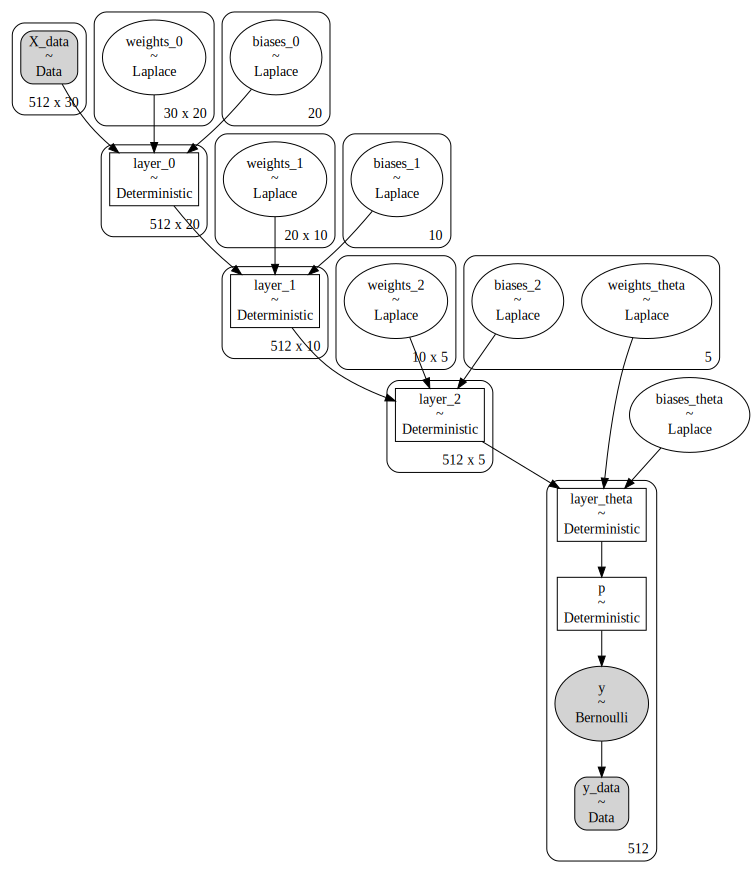

In [44]:
bernoulli_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model=bernoulli_lk,
    layers=(20, 10, 5), 
    activation='tanh',
    prior=pm.Laplace,
    mu=0,
    b=1
)
bernoulli_perceptron.show_graph()

In [45]:
bernoulli_perceptron.fit(n=30000)
bernoulli_traces = bernoulli_perceptron.predict(
    X_ts, 
    y_ts, 
    ['p'], 
    samples=3000
)

Finished [100%]: Average Loss = 379.64


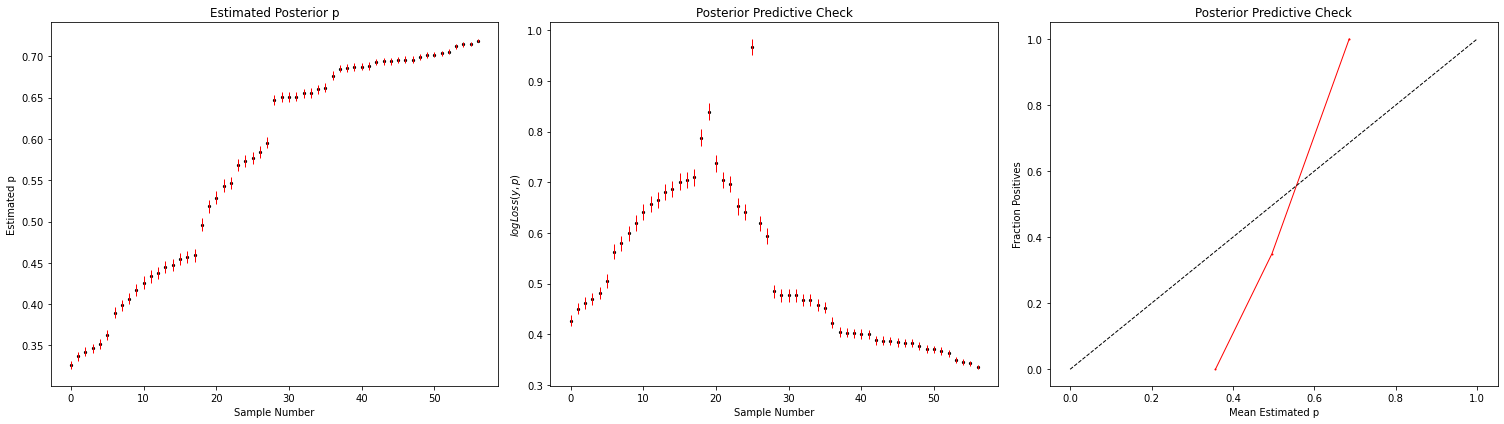

In [46]:
visulize_bernoulli_post(
    traces=bernoulli_traces, 
    y=y_ts
)

# Categorical

In [112]:
X, y = load_digits(
    return_X_y=True
)

for tr_i, ts_i in StratifiedShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

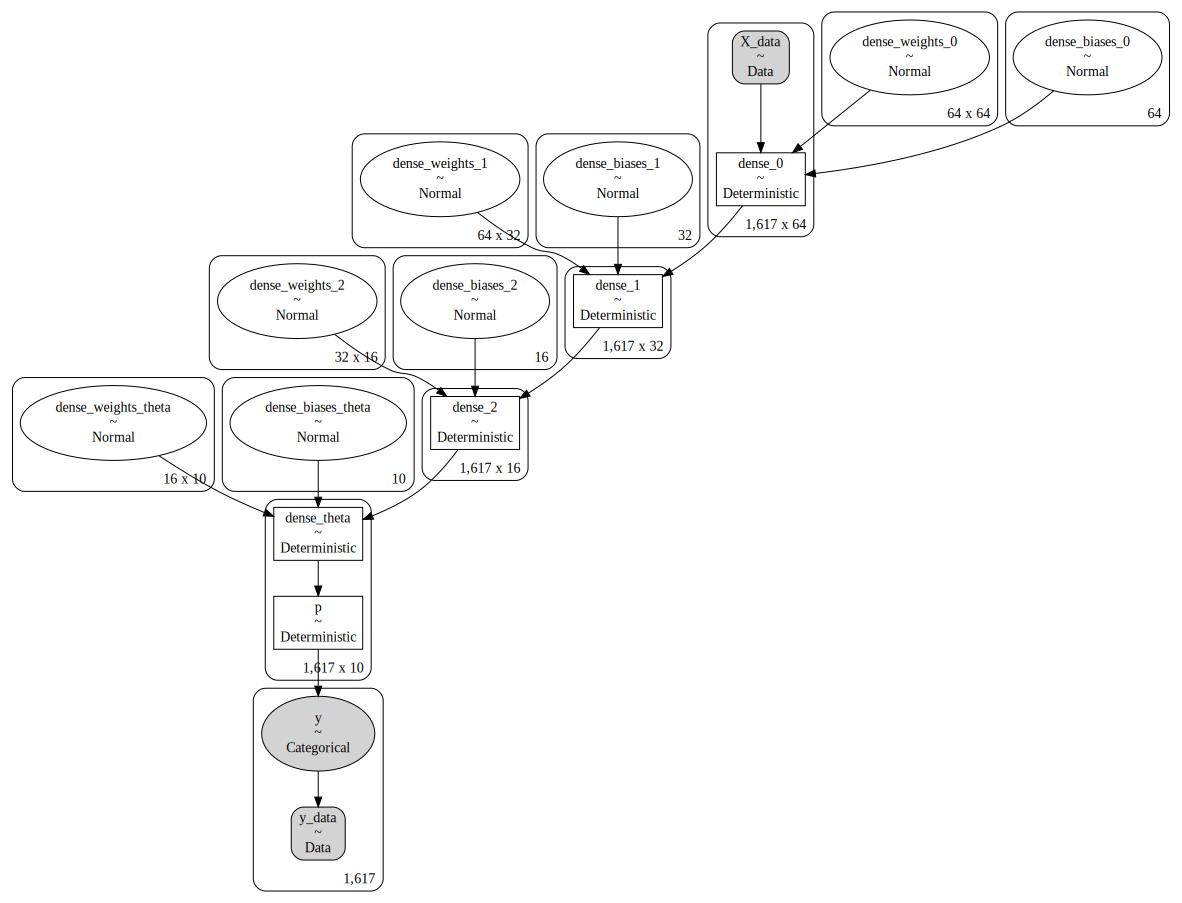

In [113]:
categorical_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=10, 
    likelyhood_model=categorical_lk,
    layers=(64, 32, 16), 
    activation='tanh',
    prior=pm.Normal,
    mu=0,
    sigma=1,
)
categorical_perceptron.show_graph()

In [114]:
categorical_perceptron.fit(n=50000)
categorical_traces = categorical_perceptron.predict(
    X_ts, 
    y_ts, 
    ['dense_1', 'p']
)

Finished [100%]: Average Loss = 3,533


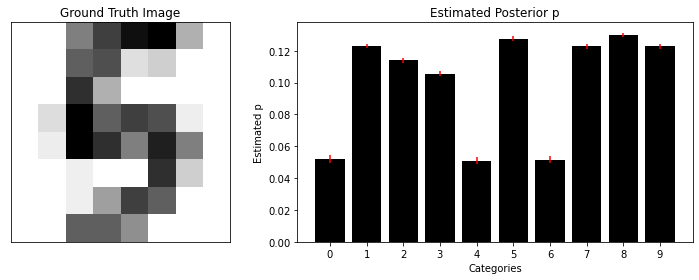

In [115]:
visulize_categorical_post(
    X=X_ts, 
    p=categorical_traces['p'],
    index=75
)

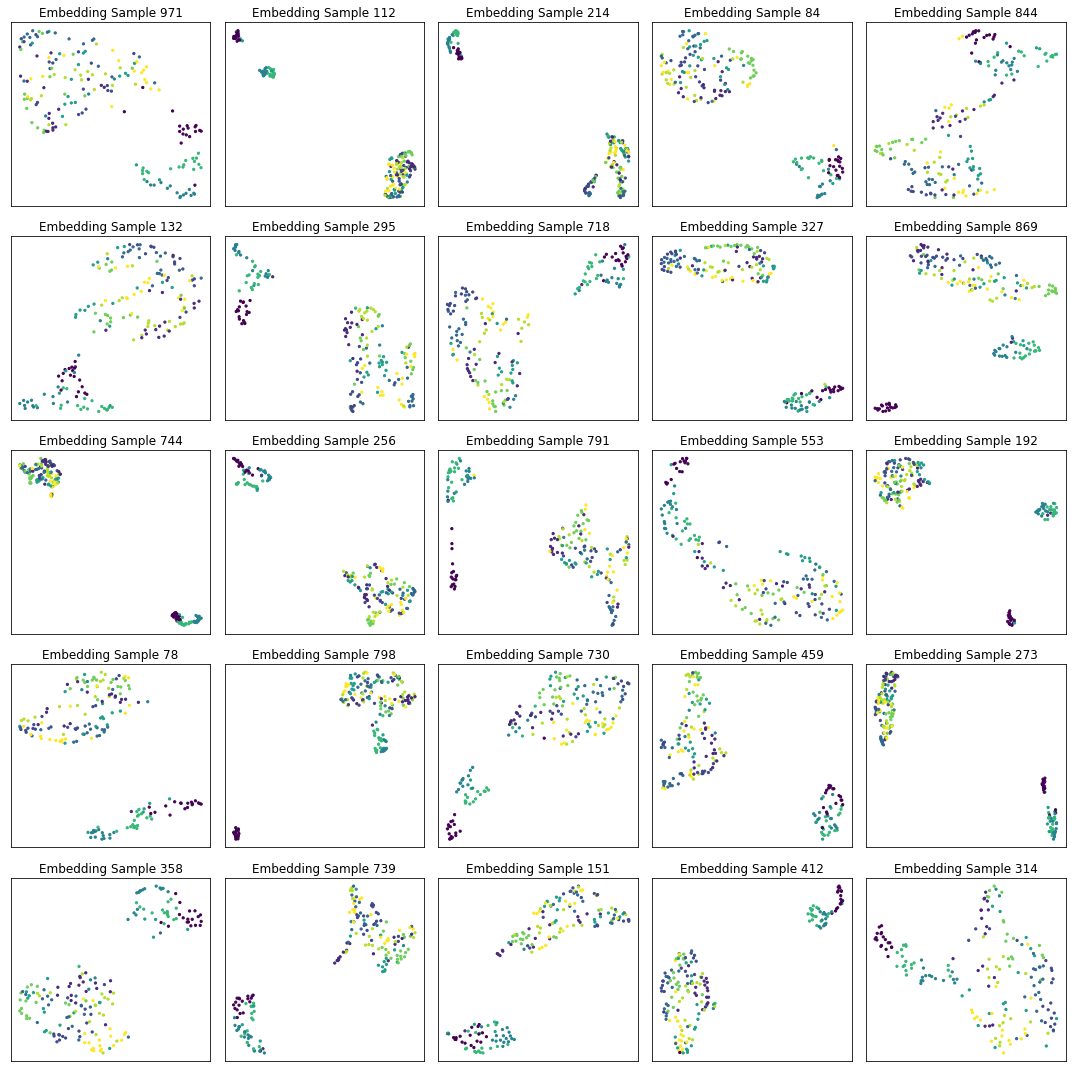

In [117]:
visualize_embedding(
    embedding=categorical_traces['dense_1'],
    y=y_ts,
    metric='cosine',
    n_epochs=2000,
    random_state=666
)

# Normal and Student-T

In [118]:
X, y = fetch_openml(
    'ASP-POTASSCO-regression',
    return_X_y=True
)
X = X.drop(
    [
        'instance_id',
        'repetition',
        'Frac_Removed_Nogood.2',
        'algorithm',
        'runstatus'
        
    ],
    axis=1
)
X = X.fillna(X.mean())

X = X.values
y = y.values

for tr_i, ts_i in ShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

In [129]:
gaussian_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model=gaussian_lk,
    layers=(128, 64, 32, 16, 8), 
    activation='tanh'
)
gaussian_perceptron.show_graph()

TypeError: __init__() missing 1 required positional argument: 'prior'

In [ ]:
gaussian_perceptron.fit(n=30000)
gaussian_traces = gaussian_perceptron.predict(
    X_ts, 
    y_ts, 
    ['y']
)

Interrupted at 32,652 [65%]: Average Loss = 7.2575e+07


# Word Embedding

In [124]:
X = np.random.choice([i for i in range(100)], size=(1000, 10))
y = np.random.choice([0, 1], size=(1000,))

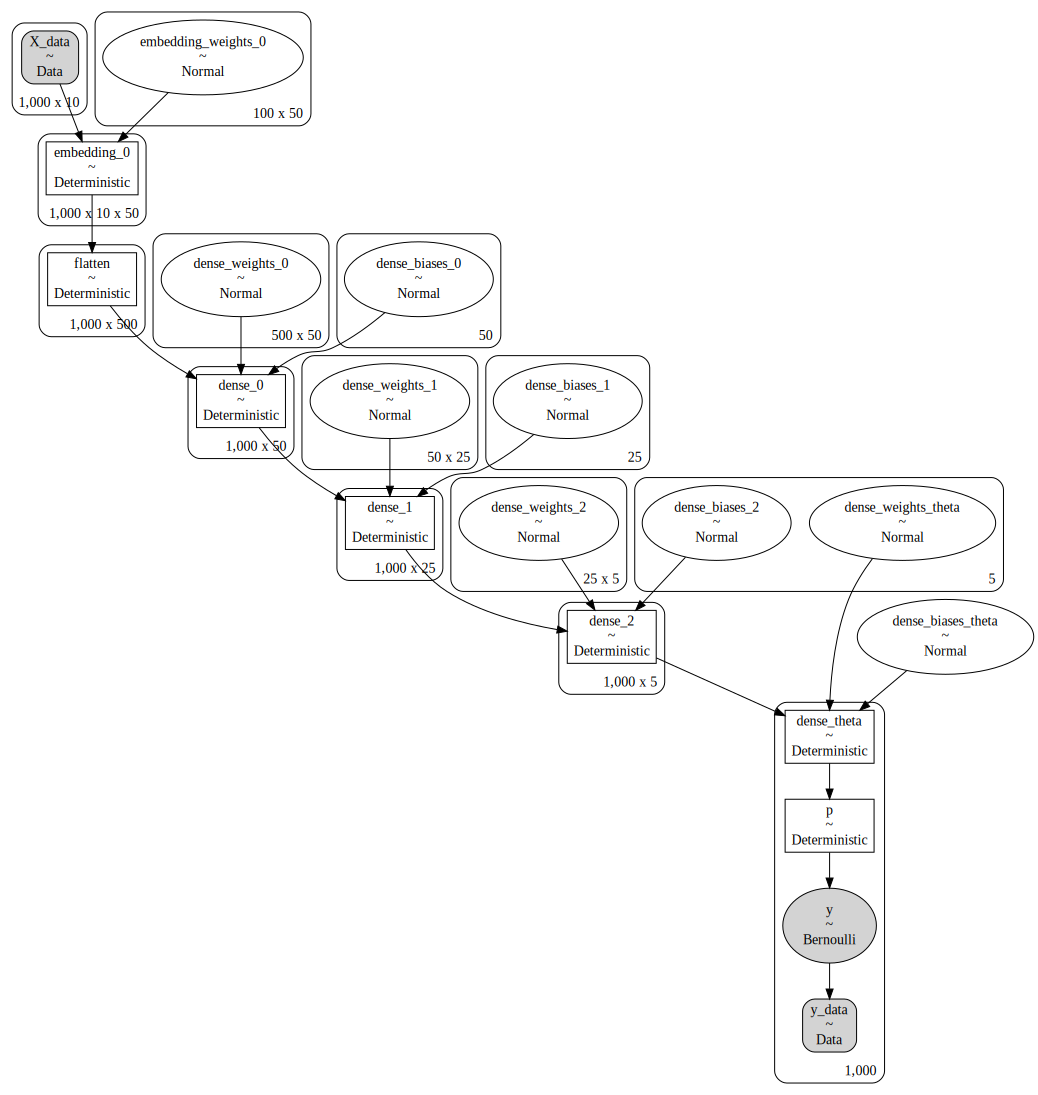

In [134]:
embedding_model = BayesianWordEmbedding(
    X, 
    y, 
    shape_out=1, 
    likelyhood_model=bernoulli_lk, 
    prior=pm.Normal,
    vocabulary_size=X.max()+1, 
    embedding_size=50, 
    layers=(50, 25, 5),
    activation='tanh', 
    weight_init_func='gaussian',
    bias_init_func='gaussian', 
    mu=0,
    sigma=1
)
embedding_model.show_graph()